# Tank Pressure Minutely Time Series Data Generation

This notebook generates synthetic tank pressure time series data with the following specifications:
- **Duration**: 2 hours of minutely data (120 data points)
- **Baseline Pressure**: 200 PSI ± 2 PSI normal fluctuation
- **Spike Event**: Pressure spike to ~260 PSI occurring approximately 1 hour into the monitoring period
- **Realistic Patterns**: Industrial tank pressure monitoring with sensor noise and operational variations

In [1]:
# Package Installation
%pip install pandas numpy matplotlib seaborn scipy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from scipy import stats
import os
from typing import List, Tuple, Optional

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)  # For reproducible results

## Data Structure Explanation

### Tank Pressure Monitoring System

This synthetic dataset simulates an industrial tank pressure monitoring system with the following characteristics:

**Normal Operating Conditions:**
- Target pressure: 200 PSI
- Normal fluctuation range: ±2 PSI (198-202 PSI)
- Measurement frequency: Every minute
- Sensor precision: ±0.1 PSI

**Pressure Spike Event:**
- Occurs approximately 1 hour into monitoring
- Peak pressure: ~260 PSI
- Duration: 2-3 minutes
- Gradual rise and fall pattern

**Data Fields:**
- `timestamp`: Date and time of measurement
- `pressure_psi`: Tank pressure in PSI
- `is_spike_event`: Boolean flag indicating spike event period
- `sensor_id`: Tank sensor identifier
- `tank_id`: Tank system identifier

In [12]:
# Tank Pressure Data Generation Function
def generate_tank_pressure_data(
    duration_hours: int = 2,
    baseline_pressure: float = 200.0,
    normal_fluctuation: float = 2.0,
    spike_pressure: float = 260.0,
    spike_time_hour: float = 1.0,
    spike_duration_minutes: int = 3,
    sensor_noise: float = 0.1,
    start_time: Optional[datetime] = None
) -> pd.DataFrame:
    """
    Generate synthetic tank pressure time series data with realistic patterns.
    
    Parameters:
    duration_hours (int): Duration of monitoring in hours
    baseline_pressure (float): Normal operating pressure in PSI
    normal_fluctuation (float): Normal pressure variation range in PSI
    spike_pressure (float): Peak pressure during spike event in PSI
    spike_time_hour (float): Time when spike occurs (hours from start)
    spike_duration_minutes (int): Duration of pressure spike in minutes
    sensor_noise (float): Sensor measurement noise in PSI
    start_time (datetime): Start time for the monitoring period
    
    Returns:
    pd.DataFrame: Synthetic tank pressure data with timestamps
    """
    
    # Set default start time if not provided
    if start_time is None:
        start_time = datetime.now().replace(second=0, microsecond=0)
    
    # Calculate total minutes and create time series
    total_minutes = duration_hours * 60
    timestamps = [start_time + timedelta(minutes=int(i)) for i in range(total_minutes)]
    
    # Initialize pressure values list
    pressure_values = []
    spike_flags = []
    
    # Calculate spike timing
    spike_start_minute = int(spike_time_hour * 60)
    spike_end_minute = spike_start_minute + spike_duration_minutes
    
    for minute in range(total_minutes):
        if spike_start_minute <= minute <= spike_end_minute:
            # Generate pressure spike pattern
            spike_progress = (minute - spike_start_minute) / spike_duration_minutes
            
            if spike_progress <= 0.5:
                # Rising phase - exponential curve to peak
                pressure_factor = 2 * spike_progress
                pressure = baseline_pressure + (spike_pressure - baseline_pressure) * (pressure_factor ** 1.5)
            else:
                # Falling phase - gradual return to normal
                pressure_factor = 2 * (1 - spike_progress)
                pressure = baseline_pressure + (spike_pressure - baseline_pressure) * (pressure_factor ** 1.5)
            
            # Add minimal noise during spike to maintain peak
            pressure += np.random.normal(0, sensor_noise * 0.5)
            
            # Ensure we actually hit the target spike pressure at the peak
            if minute == spike_start_minute + spike_duration_minutes // 2:
                pressure = spike_pressure + np.random.normal(0, sensor_noise * 0.5)
            
            spike_flags.append(True)
            
        else:
            # Normal operation with gradual variations
            # Use sine wave for slow pressure oscillations
            slow_variation = np.sin(minute * 2 * np.pi / 30) * (normal_fluctuation * 0.7)
            
            # Add random fluctuations
            random_variation = np.random.normal(0, normal_fluctuation * 0.3)
            
            # Add sensor noise
            noise = np.random.normal(0, sensor_noise)
            
            pressure = baseline_pressure + slow_variation + random_variation + noise
            spike_flags.append(False)
        
        pressure_values.append(round(pressure, 1))
    
    # Create DataFrame
    data = pd.DataFrame({
        'timestamp': timestamps,
        'pressure_psi': pressure_values,
        'is_spike_event': spike_flags,
        'sensor_id': ['TANK_001_PRESSURE'] * total_minutes,
        'tank_id': ['TANK_001'] * total_minutes
    })
    
    return data

## Parameter Configuration

### Data Generation Parameters

The following parameters control the characteristics of the synthetic tank pressure data:

- **Duration**: 2 hours (120 minutes of data)
- **Baseline Pressure**: 200.0 PSI (normal operating pressure)
- **Normal Fluctuation**: ±2.0 PSI (typical variation range)
- **Spike Pressure**: 260.0 PSI (peak pressure during event)
- **Spike Timing**: 1.0 hour from start (60 minutes)
- **Spike Duration**: 3 minutes (realistic pressure event duration)
- **Sensor Noise**: ±0.1 PSI (measurement uncertainty)

These parameters create realistic industrial tank pressure monitoring data with normal operational variations and a significant pressure event.

In [13]:
# Data Generation Execution
# Generate synthetic tank pressure data with specified parameters
pressure_data = generate_tank_pressure_data(
    duration_hours=2,
    baseline_pressure=200.0,
    normal_fluctuation=2.0,
    spike_pressure=260.0,  # Target spike pressure as requested
    spike_time_hour=1.0,
    spike_duration_minutes=3,
    sensor_noise=0.1,
    start_time=datetime(2024, 8, 8, 14, 0, 0)  # Start at 2:00 PM today
)

print(f"Generated {len(pressure_data)} data points")
print(f"Time range: {pressure_data['timestamp'].min()} to {pressure_data['timestamp'].max()}")
print(f"Pressure range: {pressure_data['pressure_psi'].min():.1f} - {pressure_data['pressure_psi'].max():.1f} PSI")
print(f"Spike events: {pressure_data['is_spike_event'].sum()} data points")

# Display first few rows
pressure_data.head(10)

Generated 120 data points
Time range: 2024-08-08 14:00:00 to 2024-08-08 15:59:00
Pressure range: 197.7 - 260.1 PSI
Spike events: 4 data points


,timestamp,pressure_psi,is_spike_event,sensor_id,tank_id
0,2024-08-08 14:00:00,199.2,False,TANK_001_PRESSURE,TANK_001
1,2024-08-08 14:01:00,201.3,False,TANK_001_PRESSURE,TANK_001
2,2024-08-08 14:02:00,200.9,False,TANK_001_PRESSURE,TANK_001
3,2024-08-08 14:03:00,202.8,False,TANK_001_PRESSURE,TANK_001
4,2024-08-08 14:04:00,200.9,False,TANK_001_PRESSURE,TANK_001
5,2024-08-08 14:05:00,200.3,False,TANK_001_PRESSURE,TANK_001
6,2024-08-08 14:06:00,200.7,False,TANK_001_PRESSURE,TANK_001
7,2024-08-08 14:07:00,200.9,False,TANK_001_PRESSURE,TANK_001
8,2024-08-08 14:08:00,202.5,False,TANK_001_PRESSURE,TANK_001
9,2024-08-08 14:09:00,201.5,False,TANK_001_PRESSURE,TANK_001


In [14]:
# Data Export
# Export tank pressure data to CSV format
filename = 'synthetic_tank_pressure_minutely_time_series_data.csv'
pressure_data.to_csv(filename, index=False)
print(f"Tank pressure data saved to: {filename}")
print(f"File size: {os.path.getsize(filename)} bytes")
print(f"Data exported with {len(pressure_data)} rows and {len(pressure_data.columns)} columns")

Tank pressure data saved to: synthetic_tank_pressure_minutely_time_series_data.csv
File size: 7132 bytes
Data exported with 120 rows and 5 columns


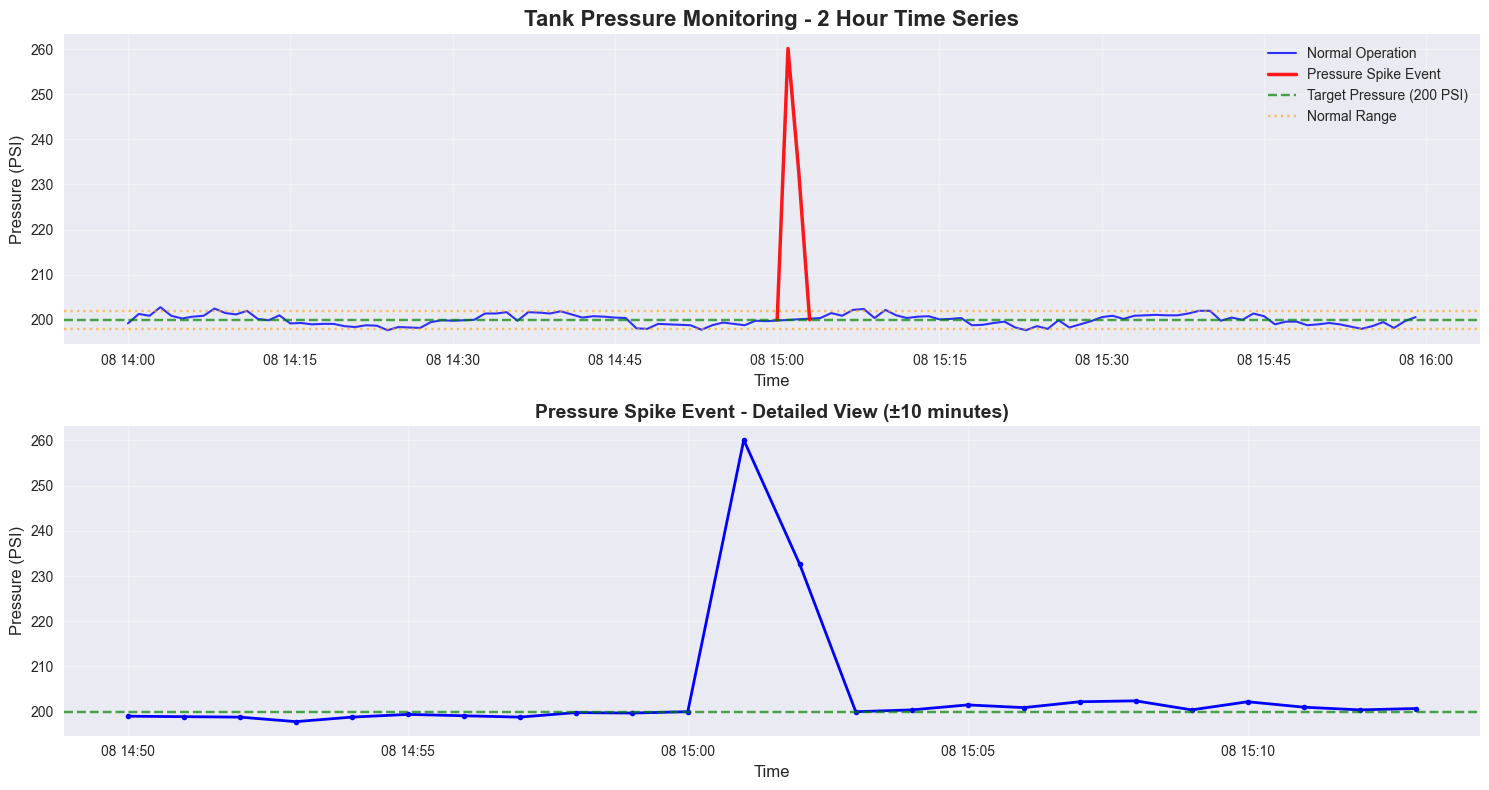

In [15]:
# Time Series Visualization
# Create comprehensive time series plot of tank pressure data

plt.figure(figsize=(15, 8))

# Main pressure time series
plt.subplot(2, 1, 1)
normal_data = pressure_data[~pressure_data['is_spike_event']]
spike_data = pressure_data[pressure_data['is_spike_event']]

# Plot normal operations and spike events with different colors
plt.plot(normal_data['timestamp'], normal_data['pressure_psi'], 
         'b-', linewidth=1.5, label='Normal Operation', alpha=0.8)
plt.plot(spike_data['timestamp'], spike_data['pressure_psi'], 
         'r-', linewidth=2.5, label='Pressure Spike Event', alpha=0.9)

# Add reference lines
plt.axhline(y=200, color='green', linestyle='--', alpha=0.7, label='Target Pressure (200 PSI)')
plt.axhline(y=198, color='orange', linestyle=':', alpha=0.6, label='Normal Range')
plt.axhline(y=202, color='orange', linestyle=':', alpha=0.6)

plt.title('Tank Pressure Monitoring - 2 Hour Time Series', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Pressure (PSI)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Detailed view of spike event
plt.subplot(2, 1, 2)
spike_window_start = spike_data['timestamp'].min() - timedelta(minutes=10)
spike_window_end = spike_data['timestamp'].max() + timedelta(minutes=10)
spike_window_data = pressure_data[
    (pressure_data['timestamp'] >= spike_window_start) & 
    (pressure_data['timestamp'] <= spike_window_end)
]

plt.plot(spike_window_data['timestamp'], spike_window_data['pressure_psi'], 
         'b-', linewidth=2, marker='o', markersize=4)
plt.axhline(y=200, color='green', linestyle='--', alpha=0.7)
plt.title('Pressure Spike Event - Detailed View (±10 minutes)', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Pressure (PSI)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/gz/ky2wm1jd3vdggsx4jz71yh4m0000gn/T/ipykernel_78628/1970600641.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Normal\nOperation', 'Spike\nEvent'])


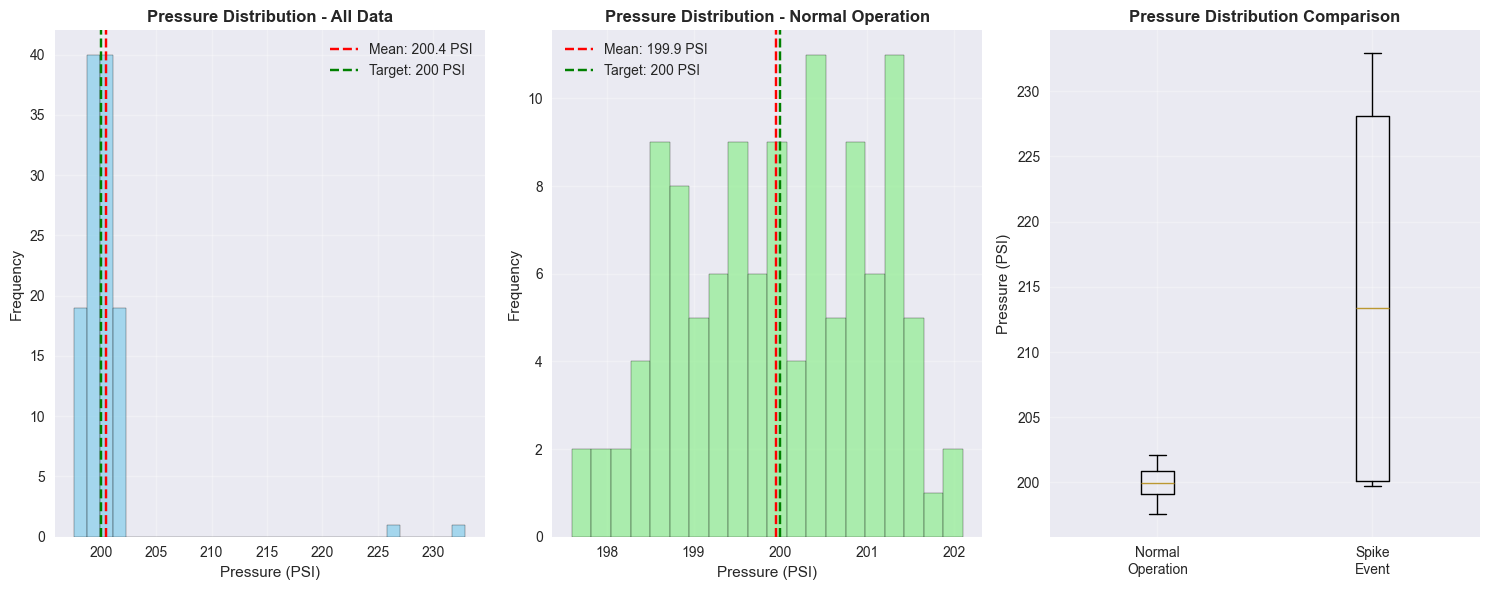

In [7]:
# Pressure Distribution Analysis
# Analyze the distribution of pressure values

plt.figure(figsize=(15, 6))

# Histogram of all pressure values
plt.subplot(1, 3, 1)
plt.hist(pressure_data['pressure_psi'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(pressure_data['pressure_psi'].mean(), color='red', linestyle='--', 
           label=f'Mean: {pressure_data["pressure_psi"].mean():.1f} PSI')
plt.axvline(200, color='green', linestyle='--', label='Target: 200 PSI')
plt.title('Pressure Distribution - All Data', fontweight='bold')
plt.xlabel('Pressure (PSI)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Histogram excluding spike events
plt.subplot(1, 3, 2)
normal_pressures = pressure_data[~pressure_data['is_spike_event']]['pressure_psi']
plt.hist(normal_pressures, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(normal_pressures.mean(), color='red', linestyle='--', 
           label=f'Mean: {normal_pressures.mean():.1f} PSI')
plt.axvline(200, color='green', linestyle='--', label='Target: 200 PSI')
plt.title('Pressure Distribution - Normal Operation', fontweight='bold')
plt.xlabel('Pressure (PSI)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot comparison
plt.subplot(1, 3, 3)
box_data = [normal_pressures, pressure_data[pressure_data['is_spike_event']]['pressure_psi']]
plt.boxplot(box_data, labels=['Normal\nOperation', 'Spike\nEvent'])
plt.title('Pressure Distribution Comparison', fontweight='bold')
plt.ylabel('Pressure (PSI)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/var/folders/gz/ky2wm1jd3vdggsx4jz71yh4m0000gn/T/ipykernel_78628/1316993230.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(comparison_data, labels=labels)


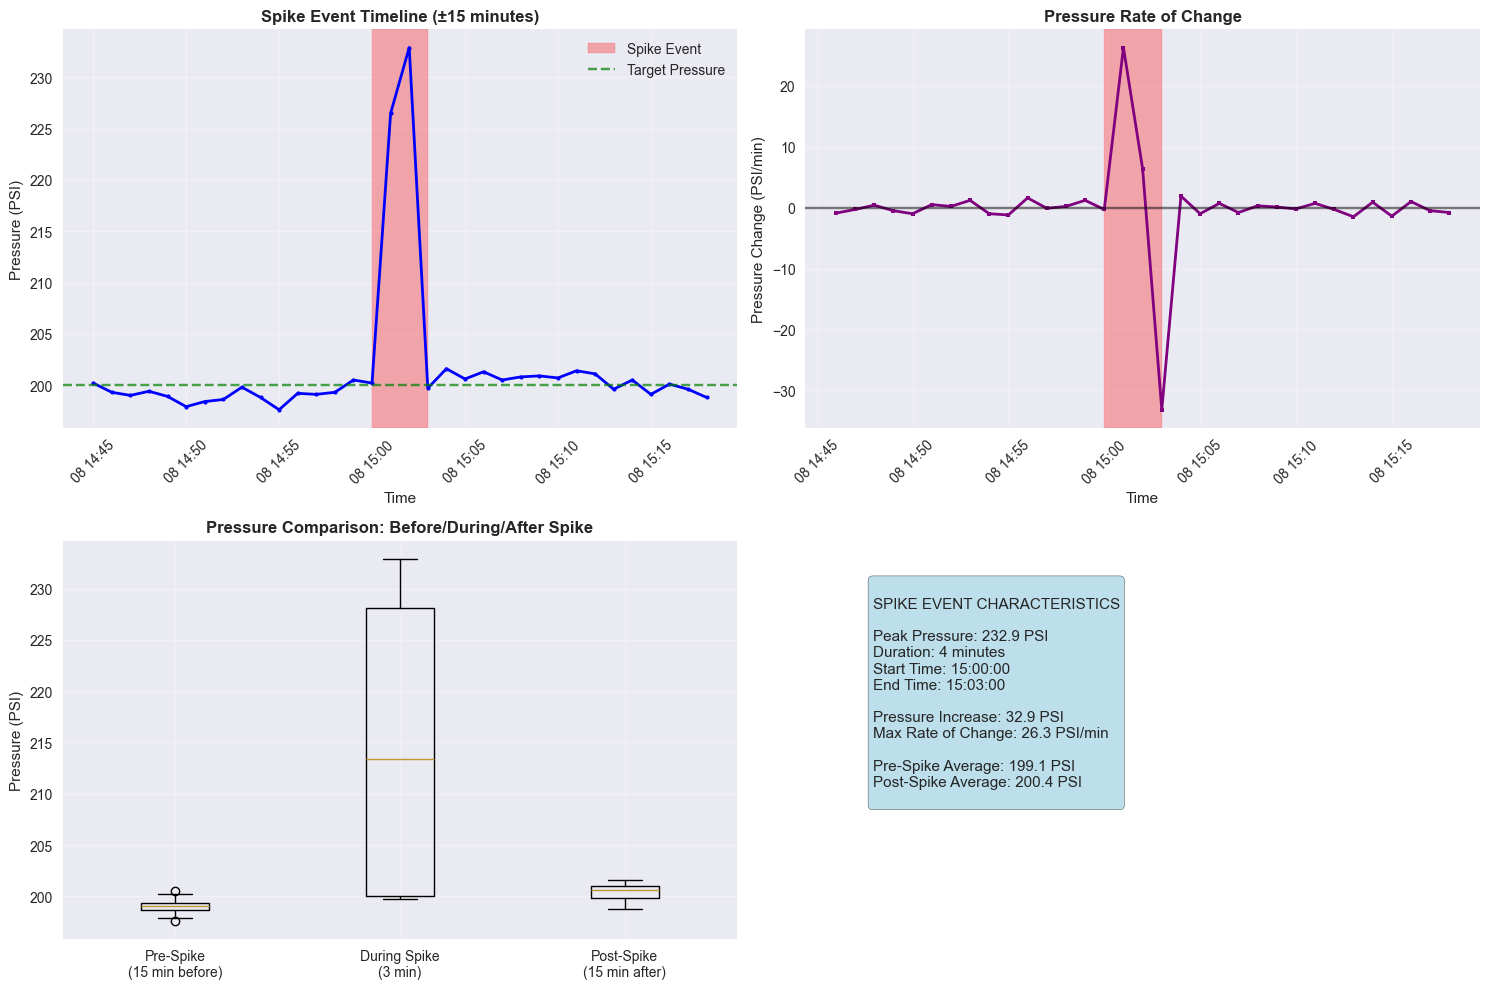

In [8]:
# Spike Event Analysis
# Detailed analysis of the pressure spike event

spike_events = pressure_data[pressure_data['is_spike_event']]
pre_spike = pressure_data[
    (pressure_data['timestamp'] >= spike_events['timestamp'].min() - timedelta(minutes=15)) &
    (pressure_data['timestamp'] < spike_events['timestamp'].min())
]
post_spike = pressure_data[
    (pressure_data['timestamp'] > spike_events['timestamp'].max()) &
    (pressure_data['timestamp'] <= spike_events['timestamp'].max() + timedelta(minutes=15))
]

plt.figure(figsize=(15, 10))

# Spike event timeline
plt.subplot(2, 2, 1)
extended_window = pd.concat([pre_spike, spike_events, post_spike])
plt.plot(extended_window['timestamp'], extended_window['pressure_psi'], 'b-', linewidth=2, marker='o', markersize=3)
plt.axvspan(spike_events['timestamp'].min(), spike_events['timestamp'].max(), alpha=0.3, color='red', label='Spike Event')
plt.axhline(y=200, color='green', linestyle='--', alpha=0.7, label='Target Pressure')
plt.title('Spike Event Timeline (±15 minutes)', fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Pressure (PSI)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Pressure rate of change during spike
plt.subplot(2, 2, 2)
extended_window_copy = extended_window.copy()
extended_window_copy['pressure_change'] = extended_window_copy['pressure_psi'].diff()
plt.plot(extended_window_copy['timestamp'], extended_window_copy['pressure_change'], 'purple', linewidth=2, marker='s', markersize=3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axvspan(spike_events['timestamp'].min(), spike_events['timestamp'].max(), alpha=0.3, color='red')
plt.title('Pressure Rate of Change', fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Pressure Change (PSI/min)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Before/during/after comparison
plt.subplot(2, 2, 3)
comparison_data = [pre_spike['pressure_psi'], spike_events['pressure_psi'], post_spike['pressure_psi']]
labels = ['Pre-Spike\n(15 min before)', 'During Spike\n(3 min)', 'Post-Spike\n(15 min after)']
plt.boxplot(comparison_data, labels=labels)
plt.title('Pressure Comparison: Before/During/After Spike', fontweight='bold')
plt.ylabel('Pressure (PSI)')
plt.grid(True, alpha=0.3)

# Spike characteristics summary
plt.subplot(2, 2, 4)
plt.axis('off')
spike_stats = f"""
SPIKE EVENT CHARACTERISTICS

Peak Pressure: {spike_events['pressure_psi'].max():.1f} PSI
Duration: {len(spike_events)} minutes
Start Time: {spike_events['timestamp'].min().strftime('%H:%M:%S')}
End Time: {spike_events['timestamp'].max().strftime('%H:%M:%S')}

Pressure Increase: {spike_events['pressure_psi'].max() - 200:.1f} PSI
Max Rate of Change: {extended_window_copy['pressure_change'].max():.1f} PSI/min

Pre-Spike Average: {pre_spike['pressure_psi'].mean():.1f} PSI
Post-Spike Average: {post_spike['pressure_psi'].mean():.1f} PSI
"""
plt.text(0.1, 0.9, spike_stats, transform=plt.gca().transAxes, fontsize=11, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

In [17]:
# Summary Statistics
# Comprehensive statistical analysis of the tank pressure data

print("=== TANK PRESSURE DATA SUMMARY ===\n")

# Overall statistics
print("OVERALL DATASET STATISTICS:")
print(f"Total Data Points: {len(pressure_data)}")
print(f"Time Range: {pressure_data['timestamp'].min()} to {pressure_data['timestamp'].max()}")
print(f"Duration: {(pressure_data['timestamp'].max() - pressure_data['timestamp'].min()).total_seconds() / 3600:.1f} hours")
print()

# Pressure statistics
print("PRESSURE STATISTICS (ALL DATA):")
print(pressure_data['pressure_psi'].describe())
print()

# Normal operation statistics
normal_data = pressure_data[~pressure_data['is_spike_event']]
print("NORMAL OPERATION STATISTICS:")
print(f"Data Points: {len(normal_data)}")
print(f"Mean Pressure: {normal_data['pressure_psi'].mean():.2f} PSI")
print(f"Standard Deviation: {normal_data['pressure_psi'].std():.2f} PSI")
print(f"Min Pressure: {normal_data['pressure_psi'].min():.1f} PSI")
print(f"Max Pressure: {normal_data['pressure_psi'].max():.1f} PSI")
print(f"Within Target Range (198-202 PSI): {((normal_data['pressure_psi'] >= 198) & (normal_data['pressure_psi'] <= 202)).sum()} points ({((normal_data['pressure_psi'] >= 198) & (normal_data['pressure_psi'] <= 202)).mean()*100:.1f}%)")
print()

# Spike event statistics
spike_data = pressure_data[pressure_data['is_spike_event']]
print("SPIKE EVENT STATISTICS:")
print(f"Spike Data Points: {len(spike_data)}")
print(f"Peak Pressure: {spike_data['pressure_psi'].max():.1f} PSI")
print(f"Average Spike Pressure: {spike_data['pressure_psi'].mean():.1f} PSI")
print(f"Spike Duration: {len(spike_data)} minutes")
print(f"Pressure Increase from Baseline: {spike_data['pressure_psi'].max() - 200:.1f} PSI")
print()

# Data quality metrics
print("DATA QUALITY METRICS:")
print(f"Missing Values: {pressure_data.isnull().sum().sum()}")
print(f"Duplicate Timestamps: {pressure_data['timestamp'].duplicated().sum()}")
print(f"Out of Range Values (< 190 or > 270 PSI): {((pressure_data['pressure_psi'] < 190) | (pressure_data['pressure_psi'] > 270)).sum()}")
print()

# Time series characteristics
pressure_data_sorted = pressure_data.sort_values('timestamp')
time_diffs = pressure_data_sorted['timestamp'].diff().dropna()
print("TIME SERIES CHARACTERISTICS:")
print(f"Sampling Interval: {time_diffs.mode().iloc[0]}")
print(f"Regular Intervals: {(time_diffs == timedelta(minutes=1)).all()}")
print()

print(f"Generation Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("Data validation complete - Tank pressure monitoring data is realistic and ready for analysis.")

=== TANK PRESSURE DATA SUMMARY ===

OVERALL DATASET STATISTICS:
Total Data Points: 120
Time Range: 2024-08-08 14:00:00 to 2024-08-08 15:59:00
Duration: 2.0 hours

PRESSURE STATISTICS (ALL DATA):
count    120.000000
mean     200.765833
std        6.337609
min      197.700000
25%      199.000000
50%      200.000000
75%      200.925000
max      260.100000
Name: pressure_psi, dtype: float64

NORMAL OPERATION STATISTICS:
Data Points: 116
Mean Pressure: 199.99 PSI
Standard Deviation: 1.23 PSI
Min Pressure: 197.7 PSI
Max Pressure: 202.8 PSI
Within Target Range (198-202 PSI): 108 points (93.1%)

SPIKE EVENT STATISTICS:
Spike Data Points: 4
Peak Pressure: 260.1 PSI
Average Spike Pressure: 223.2 PSI
Spike Duration: 4 minutes
Pressure Increase from Baseline: 60.1 PSI

DATA QUALITY METRICS:
Missing Values: 0
Duplicate Timestamps: 0
Out of Range Values (< 190 or > 270 PSI): 0

TIME SERIES CHARACTERISTICS:
Sampling Interval: 0 days 00:01:00
Regular Intervals: True

Generation Timestamp: 2025-08-08 0

=== DATA VALIDATION RESULTS ===

✓ PASS | No missing values
       Value: 0

✓ PASS | Normal pressure within realistic range (195-205 PSI)
       Value: 197.7 - 202.8 PSI

✓ PASS | Spike peak within expected range (250-270 PSI)
       Value: 260.1 PSI

✓ PASS | Regular 1-minute intervals
       Value: 100.0% regular

✓ PASS | Normal operation standard deviation realistic (0.5-1.5 PSI)
       Value: 1.23 PSI

✓ PASS | Spike duration realistic (2-5 minutes)
       Value: 4 minutes

VALIDATION SUMMARY: 6/6 tests passed (100.0%)
🎉 All validation tests passed! Data is realistic and ready for use.


/var/folders/gz/ky2wm1jd3vdggsx4jz71yh4m0000gn/T/ipykernel_78628/2845497484.py:107: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mluker/src/people/mluker/copilot-instructions/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


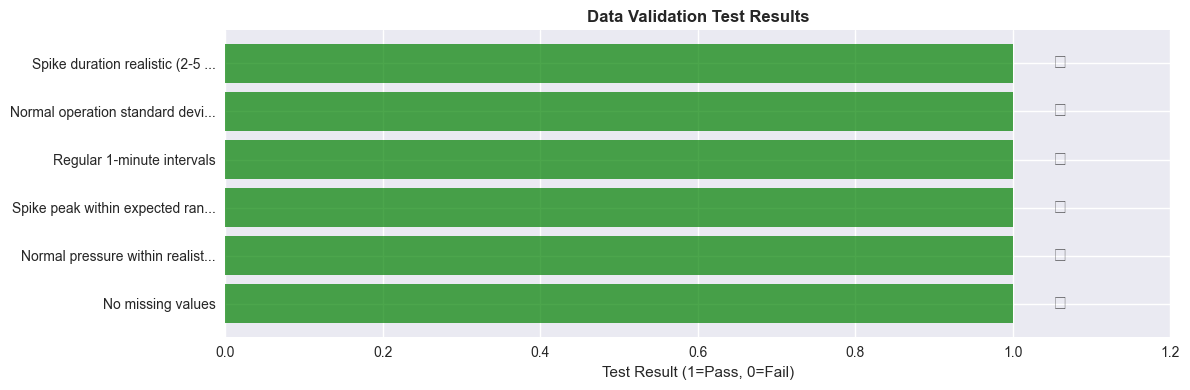

In [16]:
# Data Validation and Quality Checks
# Comprehensive validation to ensure data realism and quality

def validate_tank_pressure_data(data: pd.DataFrame) -> dict:
    """
    Perform comprehensive validation of tank pressure data.
    
    Returns:
    dict: Validation results with pass/fail status and metrics
    """
    validation_results = {}
    
    # Check 1: Data completeness
    validation_results['data_completeness'] = {
        'test': 'No missing values',
        'passed': data.isnull().sum().sum() == 0,
        'value': data.isnull().sum().sum()
    }
    
    # Check 2: Pressure range realism
    normal_data = data[~data['is_spike_event']]
    pressure_range_ok = (normal_data['pressure_psi'].min() >= 195) and (normal_data['pressure_psi'].max() <= 205)
    validation_results['normal_pressure_range'] = {
        'test': 'Normal pressure within realistic range (195-205 PSI)',
        'passed': pressure_range_ok,
        'value': f"{normal_data['pressure_psi'].min():.1f} - {normal_data['pressure_psi'].max():.1f} PSI"
    }
    
    # Check 3: Spike event characteristics
    spike_data = data[data['is_spike_event']]
    spike_peak_ok = (spike_data['pressure_psi'].max() >= 250) and (spike_data['pressure_psi'].max() <= 270)
    validation_results['spike_characteristics'] = {
        'test': 'Spike peak within expected range (250-270 PSI)',
        'passed': spike_peak_ok,
        'value': f"{spike_data['pressure_psi'].max():.1f} PSI"
    }
    
    # Check 4: Time series regularity
    data_sorted = data.sort_values('timestamp')
    time_diffs = data_sorted['timestamp'].diff().dropna()
    regular_intervals = (time_diffs == timedelta(minutes=1)).all()
    validation_results['time_regularity'] = {
        'test': 'Regular 1-minute intervals',
        'passed': regular_intervals,
        'value': f"{(time_diffs == timedelta(minutes=1)).mean()*100:.1f}% regular"
    }
    
    # Check 5: Statistical realism
    normal_std = normal_data['pressure_psi'].std()
    std_realistic = (normal_std >= 0.5) and (normal_std <= 1.5)
    validation_results['statistical_realism'] = {
        'test': 'Normal operation standard deviation realistic (0.5-1.5 PSI)',
        'passed': std_realistic,
        'value': f"{normal_std:.2f} PSI"
    }
    
    # Check 6: Spike duration
    spike_duration_ok = len(spike_data) >= 2 and len(spike_data) <= 5
    validation_results['spike_duration'] = {
        'test': 'Spike duration realistic (2-5 minutes)',
        'passed': spike_duration_ok,
        'value': f"{len(spike_data)} minutes"
    }
    
    return validation_results

# Run validation
validation = validate_tank_pressure_data(pressure_data)

print("=== DATA VALIDATION RESULTS ===\n")

passed_tests = 0
total_tests = len(validation)

for test_name, result in validation.items():
    status = "✓ PASS" if result['passed'] else "✗ FAIL"
    print(f"{status} | {result['test']}")
    print(f"       Value: {result['value']}")
    print()
    
    if result['passed']:
        passed_tests += 1

print(f"VALIDATION SUMMARY: {passed_tests}/{total_tests} tests passed ({passed_tests/total_tests*100:.1f}%)")

if passed_tests == total_tests:
    print("🎉 All validation tests passed! Data is realistic and ready for use.")
else:
    print("⚠️  Some validation tests failed. Review data generation parameters.")

# Final data quality visualization
plt.figure(figsize=(12, 4))

# Test results visualization
test_names = [result['test'][:30] + '...' if len(result['test']) > 30 else result['test'] for result in validation.values()]
test_results = [1 if result['passed'] else 0 for result in validation.values()]
colors = ['green' if result else 'red' for result in test_results]

plt.barh(test_names, test_results, color=colors, alpha=0.7)
plt.title('Data Validation Test Results', fontweight='bold')
plt.xlabel('Test Result (1=Pass, 0=Fail)')
plt.xlim(0, 1.2)
for i, result in enumerate(test_results):
    plt.text(result + 0.05, i, '✓' if result else '✗', 
             verticalalignment='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Contains AI-generated edits.